Q1.
A)

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import models

Files already downloaded and verified
Files already downloaded and verified


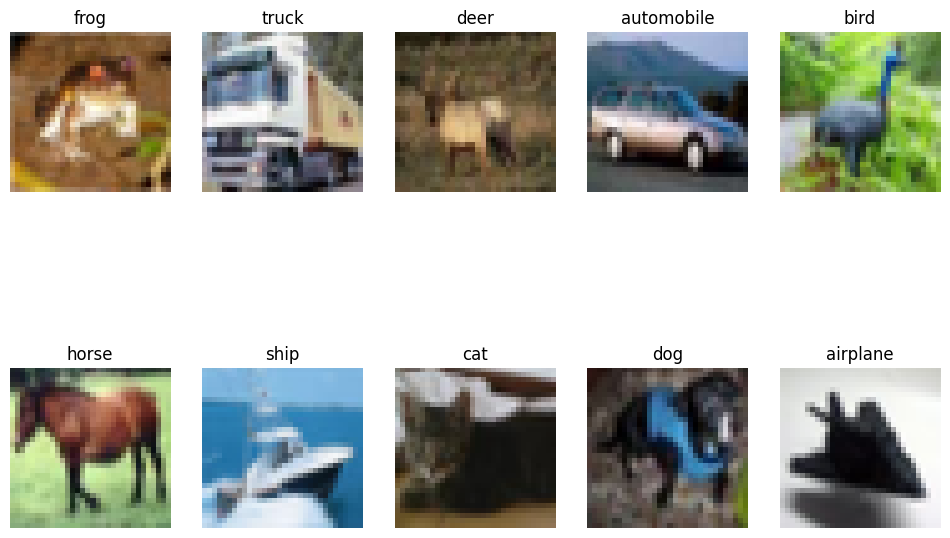

In [25]:
transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = 45000
valid_size = 5000
train_data, valid_data = torch.utils.data.random_split(trainset, [train_size, valid_size])

batch_size = 128


trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class_images = {}

for image, label in trainset:
    if label not in class_images:
        class_images[label] = image
    if len(class_images) == len(classes):
        break

plt.figure(figsize=(12, 8))
for idx, (label, img) in enumerate(class_images.items()):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.subplot(2, 5, idx + 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(classes[label])
    plt.axis('off')

plt.show()

B)

In [26]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [27]:
epochs =10
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=learning_rate)


Epoch 1/10, Train Loss: 1.4665, Train Acc: 48.70%, Valid Loss: 1.2885, Valid Acc: 52.92%
Epoch 2/10, Train Loss: 1.1951, Train Acc: 58.39%, Valid Loss: 1.1779, Valid Acc: 58.58%
Epoch 3/10, Train Loss: 1.0723, Train Acc: 63.04%, Valid Loss: 1.1037, Valid Acc: 60.90%
Epoch 4/10, Train Loss: 1.0012, Train Acc: 65.48%, Valid Loss: 1.0711, Valid Acc: 62.56%
Epoch 5/10, Train Loss: 0.9521, Train Acc: 67.31%, Valid Loss: 1.0680, Valid Acc: 62.64%
Epoch 6/10, Train Loss: 0.9156, Train Acc: 68.65%, Valid Loss: 1.0400, Valid Acc: 63.88%
Epoch 7/10, Train Loss: 0.8860, Train Acc: 69.64%, Valid Loss: 1.0514, Valid Acc: 62.90%
Epoch 8/10, Train Loss: 0.8538, Train Acc: 70.69%, Valid Loss: 1.0270, Valid Acc: 64.26%
Epoch 9/10, Train Loss: 0.8342, Train Acc: 71.43%, Valid Loss: 1.0310, Valid Acc: 64.34%
Epoch 10/10, Train Loss: 0.8122, Train Acc: 72.15%, Valid Loss: 1.0208, Valid Acc: 65.20%


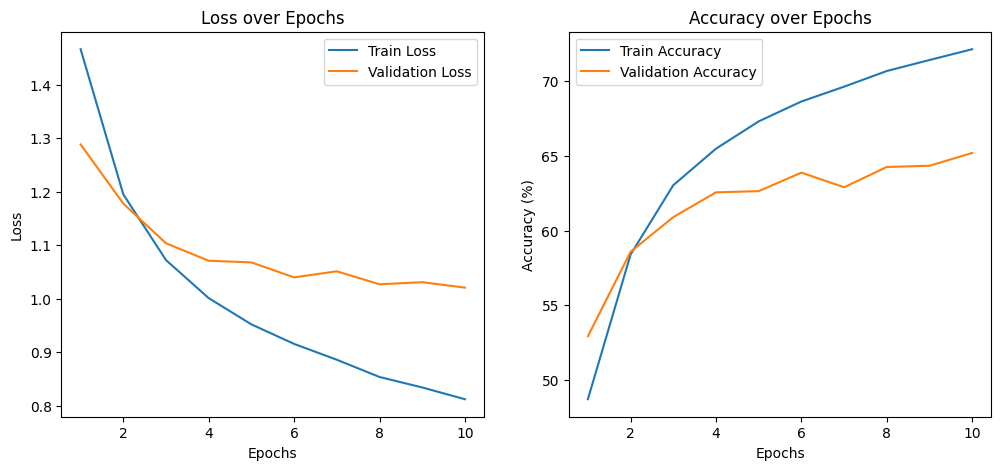

In [28]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(epochs):
    baseline_model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = baseline_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(100. * correct / total)
    
    baseline_model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = baseline_model(inputs)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    valid_losses.append(valid_loss / len(validloader))
    valid_accuracies.append(100. * correct / total)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_accuracies[-1]:.2f}%")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

torch.save(baseline_model.state_dict(), 'best_baseline_model.pth')

c)

In [31]:
class UpgradedModel(nn.Module):
    def __init__(self):
        super(UpgradedModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=128*8*8, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Epoch 1/6, Train Loss: 1.3094, Train Acc: 53.02%, Valid Loss: 1.0061, Valid Acc: 64.10%
Epoch 2/6, Train Loss: 0.8643, Train Acc: 69.54%, Valid Loss: 0.8497, Valid Acc: 68.22%
Epoch 3/6, Train Loss: 0.6574, Train Acc: 76.85%, Valid Loss: 0.7068, Valid Acc: 74.48%
Epoch 4/6, Train Loss: 0.4812, Train Acc: 83.27%, Valid Loss: 0.7144, Valid Acc: 74.70%
Epoch 5/6, Train Loss: 0.3120, Train Acc: 89.10%, Valid Loss: 0.7282, Valid Acc: 75.70%
Epoch 6/6, Train Loss: 0.1711, Train Acc: 94.21%, Valid Loss: 0.8865, Valid Acc: 73.70%


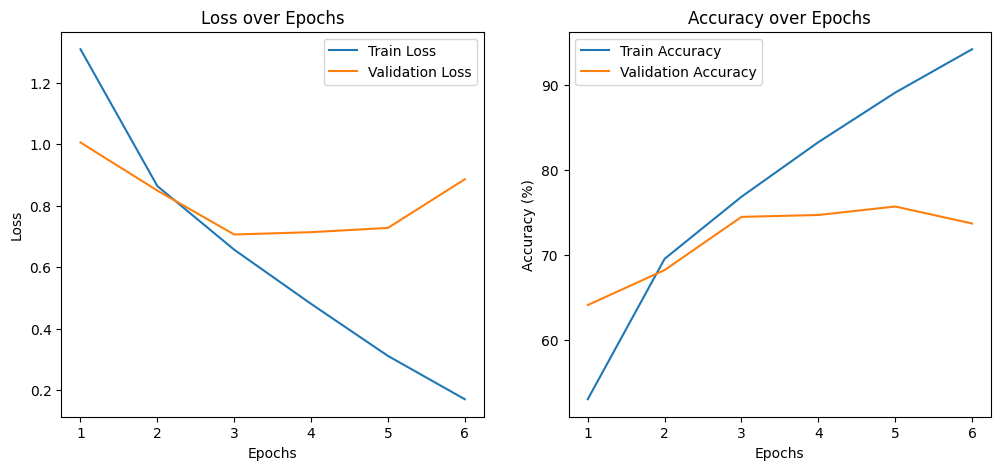

In [34]:
batch_size = 128
epochs = 6
learning_rate = 0.001

model = UpgradedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []


for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(100. * correct / total)
    
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    valid_losses.append(valid_loss / len(validloader))
    valid_accuracies.append(100. * correct / total)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_accuracies[-1]:.2f}%")
    

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Save the best model
torch.save(model.state_dict(), 'best_upgraded_model.pth')

after 5 epochs it reches the early stoping point

d)

In [35]:
class UpgradedModelWithBN(nn.Module):
    def __init__(self):
        super(UpgradedModelWithBN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1/6, Train Loss: 1.2388, Train Acc: 54.63%, Valid Loss: 1.0744, Valid Acc: 60.78%
Epoch 2/6, Train Loss: 0.8116, Train Acc: 71.40%, Valid Loss: 0.7959, Valid Acc: 71.78%
Epoch 3/6, Train Loss: 0.6412, Train Acc: 77.52%, Valid Loss: 0.7431, Valid Acc: 72.80%
Epoch 4/6, Train Loss: 0.5325, Train Acc: 81.49%, Valid Loss: 0.7579, Valid Acc: 74.30%
Epoch 5/6, Train Loss: 0.4372, Train Acc: 84.71%, Valid Loss: 0.7121, Valid Acc: 75.94%
Epoch 6/6, Train Loss: 0.3549, Train Acc: 87.56%, Valid Loss: 0.7418, Valid Acc: 77.00%


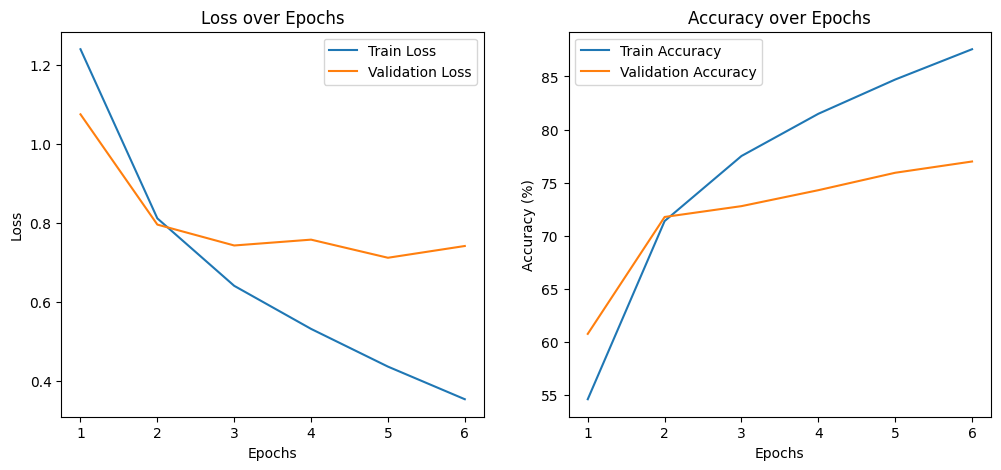

In [44]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

model = UpgradedModelWithBN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


epochs = 6

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(100. * correct / total)

    model.eval()
    valid_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    valid_losses.append(valid_loss / len(validloader))
    valid_accuracies.append(100. * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_accuracies[-1]:.2f}%")

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Save the best model
torch.save(model.state_dict(), 'best_model_with_bn.pth')

the results are better

e)

the d part is the best model.

In [45]:
class UpgradedModelWithBNAndDropout(nn.Module):
    def __init__(self):
        super(UpgradedModelWithBNAndDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


Epoch 1/6, Train Loss: 1.4343, Train Acc: 47.25%, Valid Loss: 1.2040, Valid Acc: 55.62%
Epoch 2/6, Train Loss: 1.0226, Train Acc: 64.03%, Valid Loss: 0.9721, Valid Acc: 65.84%
Epoch 3/6, Train Loss: 0.8604, Train Acc: 70.40%, Valid Loss: 0.8405, Valid Acc: 69.86%
Epoch 4/6, Train Loss: 0.7481, Train Acc: 74.43%, Valid Loss: 0.8754, Valid Acc: 70.88%
Epoch 5/6, Train Loss: 0.6566, Train Acc: 77.87%, Valid Loss: 0.7321, Valid Acc: 75.18%
Epoch 6/6, Train Loss: 0.5756, Train Acc: 80.53%, Valid Loss: 0.6866, Valid Acc: 76.82%


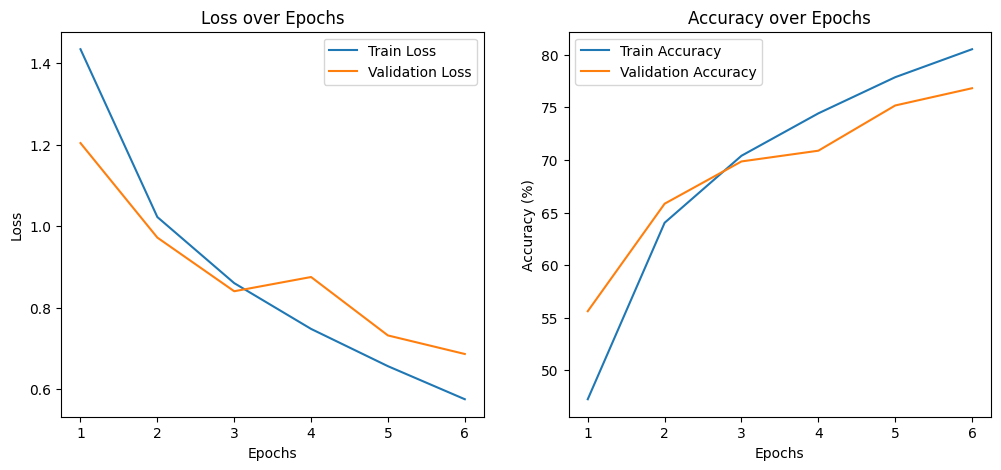

In [46]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

model = UpgradedModelWithBNAndDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


epochs = 6

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(100. * correct / total)

    model.eval()
    valid_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    valid_losses.append(valid_loss / len(validloader))
    valid_accuracies.append(100. * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_accuracies[-1]:.2f}%")

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Save the best model
torch.save(model.state_dict(), 'best_model_with_bn_and_dropout.pth')

part d was slightly better in accuracy

f)

the best is still d

Test Accuracy (Model d - With BN and Dropout): 76.89%


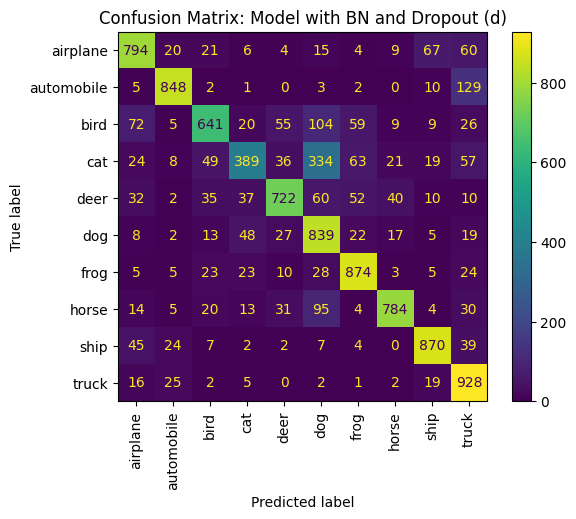

In [49]:
# Load the best model (update the file name for each part accordingly)
# model_b = UpgradedModel().to(device)
# model_b.load_state_dict(torch.load('best_upgraded_model.pth'))

# model_c = UpgradedModelWithBN().to(device)
# model_c.load_state_dict(torch.load('best_model_with_bn.pth'))

model_d = UpgradedModelWithBNAndDropout().to(device)
model_d.load_state_dict(torch.load('best_model_with_bn.pth'))

def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100. * correct / total
    return accuracy, all_preds, all_labels


# test_accuracy_b, preds_b, labels_b = evaluate_model(model_b, testloader, device)
# test_accuracy_c, preds_c, labels_c = evaluate_model(model_c, testloader, device)
test_accuracy_d, preds_d, labels_d = evaluate_model(model_d, testloader, device)

def plot_confusion_matrix(labels, preds, model_name):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

# print(f"Test Accuracy (Model b - Baseline): {test_accuracy_b:.2f}%")
# print(f"Test Accuracy (Model c - With BN): {test_accuracy_c:.2f}%")
print(f"Test Accuracy (Model d - With BN and Dropout): {test_accuracy_d:.2f}%")

# plot_confusion_matrix(labels_b, preds_b, 'Baseline Model (b)')
# plot_confusion_matrix(labels_c, preds_c, 'Model with BN (c)')
plot_confusion_matrix(labels_d, preds_d, 'Model with BN and Dropout (d)')


Q2)


a)

In [81]:
from torchvision import datasets, transforms, models

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter only the airplane and automobile classes
class_mapping = {0: 'airplane', 1: 'automobile'}
train_dataset.targets = torch.tensor(train_dataset.targets)
test_dataset.targets = torch.tensor(test_dataset.targets)

train_idx = (train_dataset.targets == 0) | (train_dataset.targets == 1)
test_idx = (test_dataset.targets == 0) | (test_dataset.targets == 1)

train_dataset.data = train_dataset.data[train_idx]
train_dataset.targets = train_dataset.targets[train_idx]

test_dataset.data = test_dataset.data[test_idx]
test_dataset.targets = test_dataset.targets[test_idx]
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.2160, Accuracy: 91.97%
Epoch 2/10, Loss: 0.0748, Accuracy: 97.35%
Epoch 3/10, Loss: 0.0400, Accuracy: 98.65%
Epoch 4/10, Loss: 0.0844, Accuracy: 97.12%
Epoch 5/10, Loss: 0.0373, Accuracy: 98.76%
Epoch 6/10, Loss: 0.0224, Accuracy: 99.20%
Epoch 7/10, Loss: 0.0115, Accuracy: 99.65%
Epoch 8/10, Loss: 0.0213, Accuracy: 99.42%
Epoch 9/10, Loss: 0.0404, Accuracy: 98.51%
Epoch 10/10, Loss: 0.0112, Accuracy: 99.69%


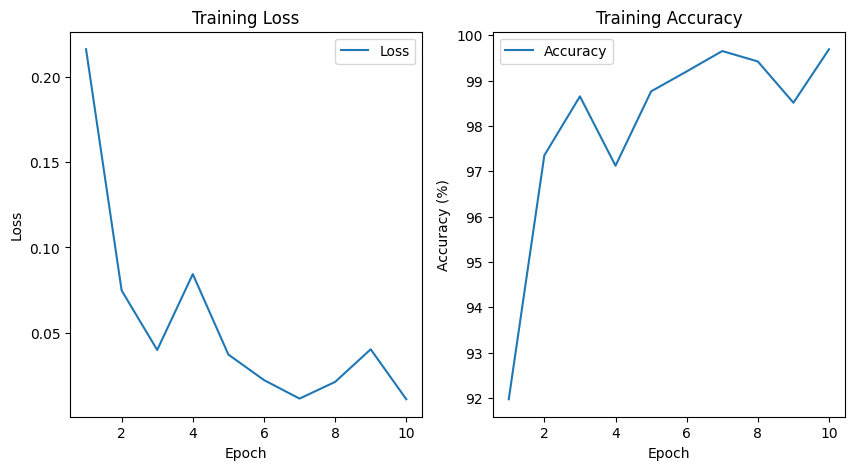

In [82]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()

plt.show()


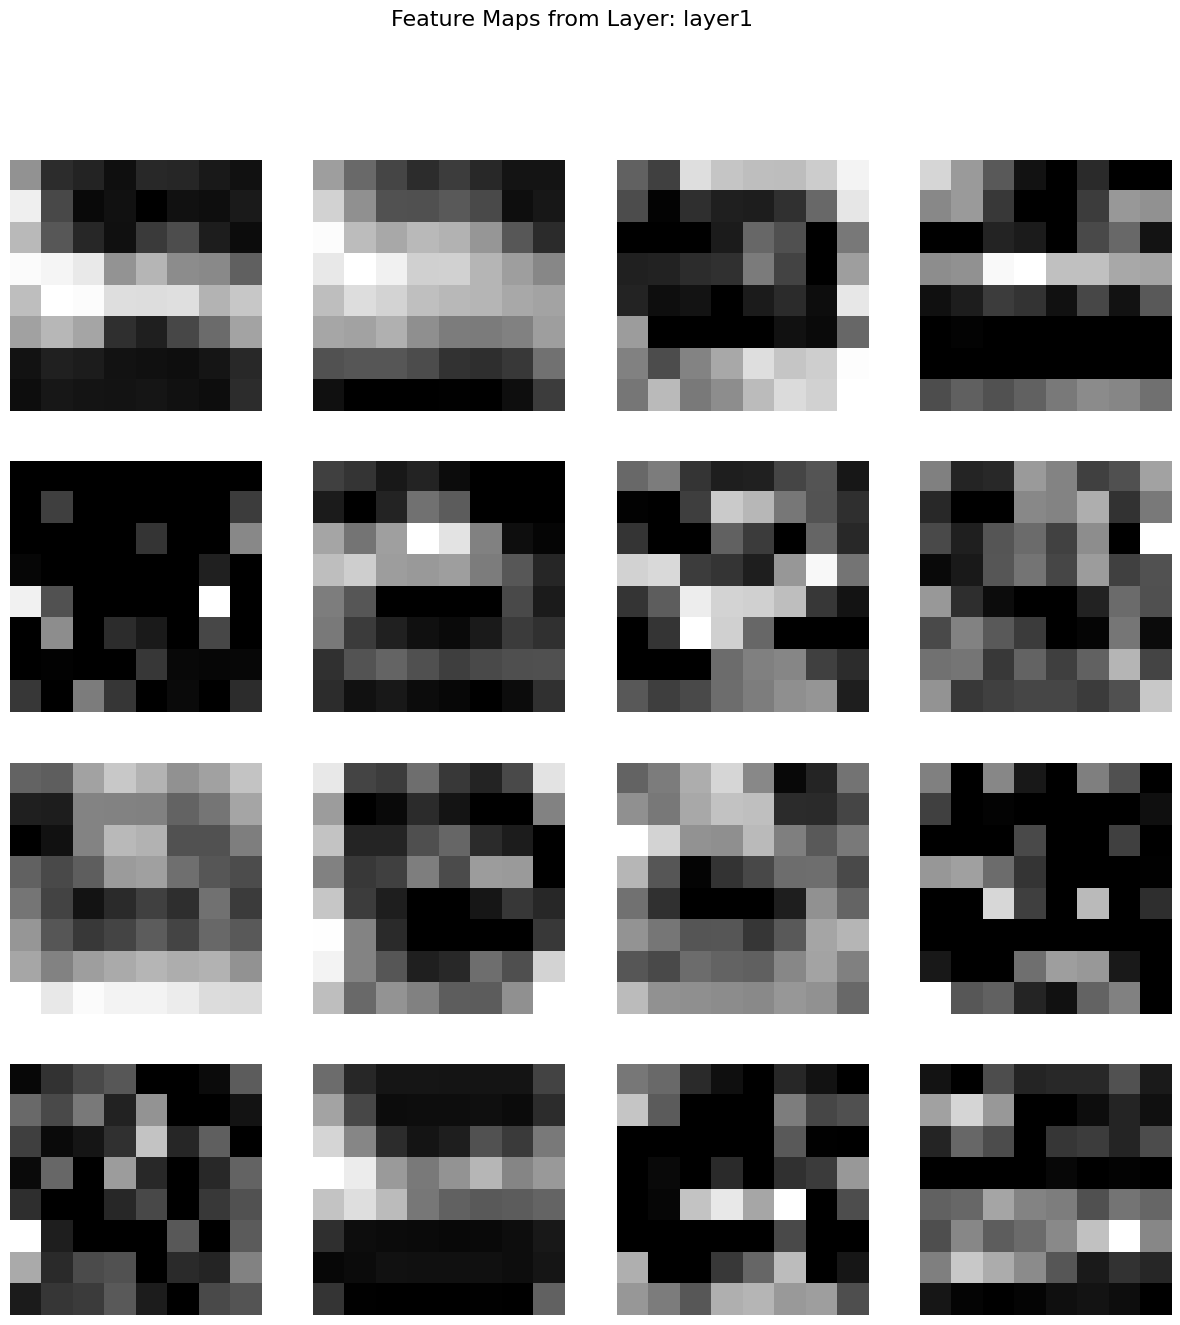

In [84]:
def visualize_feature_maps(model, layer_name, inputs):

    inputs = inputs.to(device)
    
    feature_maps = []

    def hook_fn(module, input, output):
        feature_maps.append(output)

    hook = getattr(model, layer_name).register_forward_hook(hook_fn)

    with torch.no_grad():
        model(inputs)

    hook.remove()

    feature_maps = feature_maps[0].cpu().numpy()
    num_maps = feature_maps.shape[1]  

    plt.figure(figsize=(15, 15))
    for i in range(min(num_maps, 16)): 
        plt.subplot(4, 4, i+1)
        plt.imshow(feature_maps[0, i, :, :], cmap='gray')
        plt.axis("off")
    plt.suptitle(f"Feature Maps from Layer: {layer_name}", fontsize=16)
    plt.show()

inputs, _ = next(iter(train_loader))  
visualize_feature_maps(model, "layer1", inputs)


b)

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        return x

class TripletNetwork(nn.Module):
    def __init__(self):
        super(TripletNetwork, self).__init__()
        self.feature_extractor = FeatureExtractor()

    def forward(self, anchor, positive, negative):
        anchor_features = self.feature_extractor(anchor)
        positive_features = self.feature_extractor(positive)
        negative_features = self.feature_extractor(negative)
        return anchor_features, positive_features, negative_features

def triplet_loss(anchor, positive, negative, margin=1.0):
    positive_dist = torch.nn.functional.pairwise_distance(anchor, positive)
    negative_dist = torch.nn.functional.pairwise_distance(anchor, negative)
    loss = torch.relu(positive_dist - negative_dist + margin)
    return loss.mean()

Epoch 1/10, Loss: 0.2202
Epoch 2/10, Loss: 0.1921
Epoch 3/10, Loss: 0.1765
Epoch 4/10, Loss: 0.2019
Epoch 5/10, Loss: 0.1923
Epoch 6/10, Loss: 0.1994
Epoch 7/10, Loss: 0.1946
Epoch 8/10, Loss: 0.1893
Epoch 9/10, Loss: 0.1791
Epoch 10/10, Loss: 0.1816


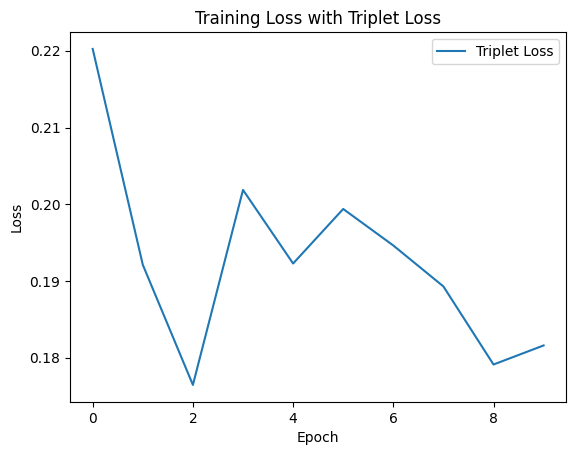

In [60]:
model = TripletNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_loss = []

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in trainloader:
        inputs, labels = data

        # Create triplets
        mask = (labels == 0) | (labels == 1)
        inputs, labels = inputs[mask], labels[mask]
        if len(inputs) < 30:
            continue

        anchor, positive, negative = inputs[:10], inputs[10:20], inputs[20:30]

        optimizer.zero_grad()
        anchor_features, positive_features, negative_features = model(anchor, positive, negative)
        loss = triplet_loss(anchor_features, positive_features, negative_features)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    train_loss.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

plt.figure()
plt.plot(range(num_epochs), train_loss, label='Triplet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with Triplet Loss')
plt.legend()
plt.show()


Epoch 1/10, Loss: 0.5089, Accuracy: 76.74%
Epoch 2/10, Loss: 0.3949, Accuracy: 82.68%
Epoch 3/10, Loss: 0.3717, Accuracy: 83.51%
Epoch 4/10, Loss: 0.3525, Accuracy: 84.47%
Epoch 5/10, Loss: 0.3501, Accuracy: 84.57%
Epoch 6/10, Loss: 0.3299, Accuracy: 85.30%
Epoch 7/10, Loss: 0.3227, Accuracy: 85.65%
Epoch 8/10, Loss: 0.3155, Accuracy: 86.15%
Epoch 9/10, Loss: 0.3097, Accuracy: 86.51%
Epoch 10/10, Loss: 0.3068, Accuracy: 86.57%


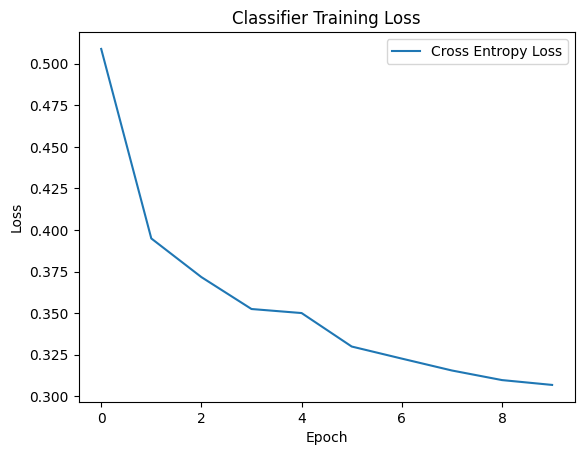

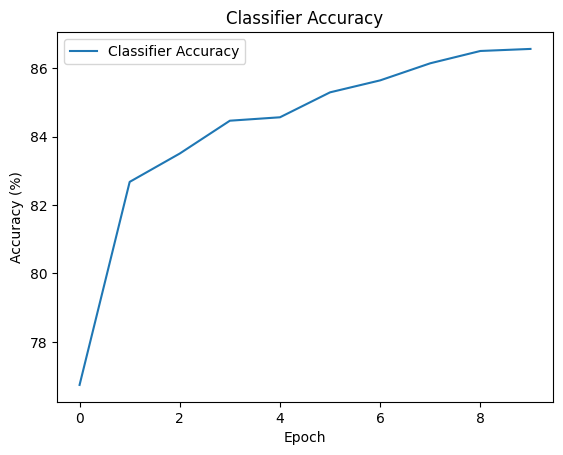

In [61]:
# Freeze Feature Extractor and Train Classifier with Cross Entropy Loss
class Classifier(nn.Module):
    def __init__(self, feature_extractor):
        super(Classifier, self).__init__()
        self.feature_extractor = feature_extractor
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

classifier = Classifier(model.feature_extractor)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        mask = (labels == 0) | (labels == 1)
        inputs, labels = inputs[mask], labels[mask]

        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

plt.figure()
plt.plot(range(num_epochs), train_loss, label='Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classifier Training Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(num_epochs), train_accuracy, label='Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Classifier Accuracy')
plt.legend()
plt.show()

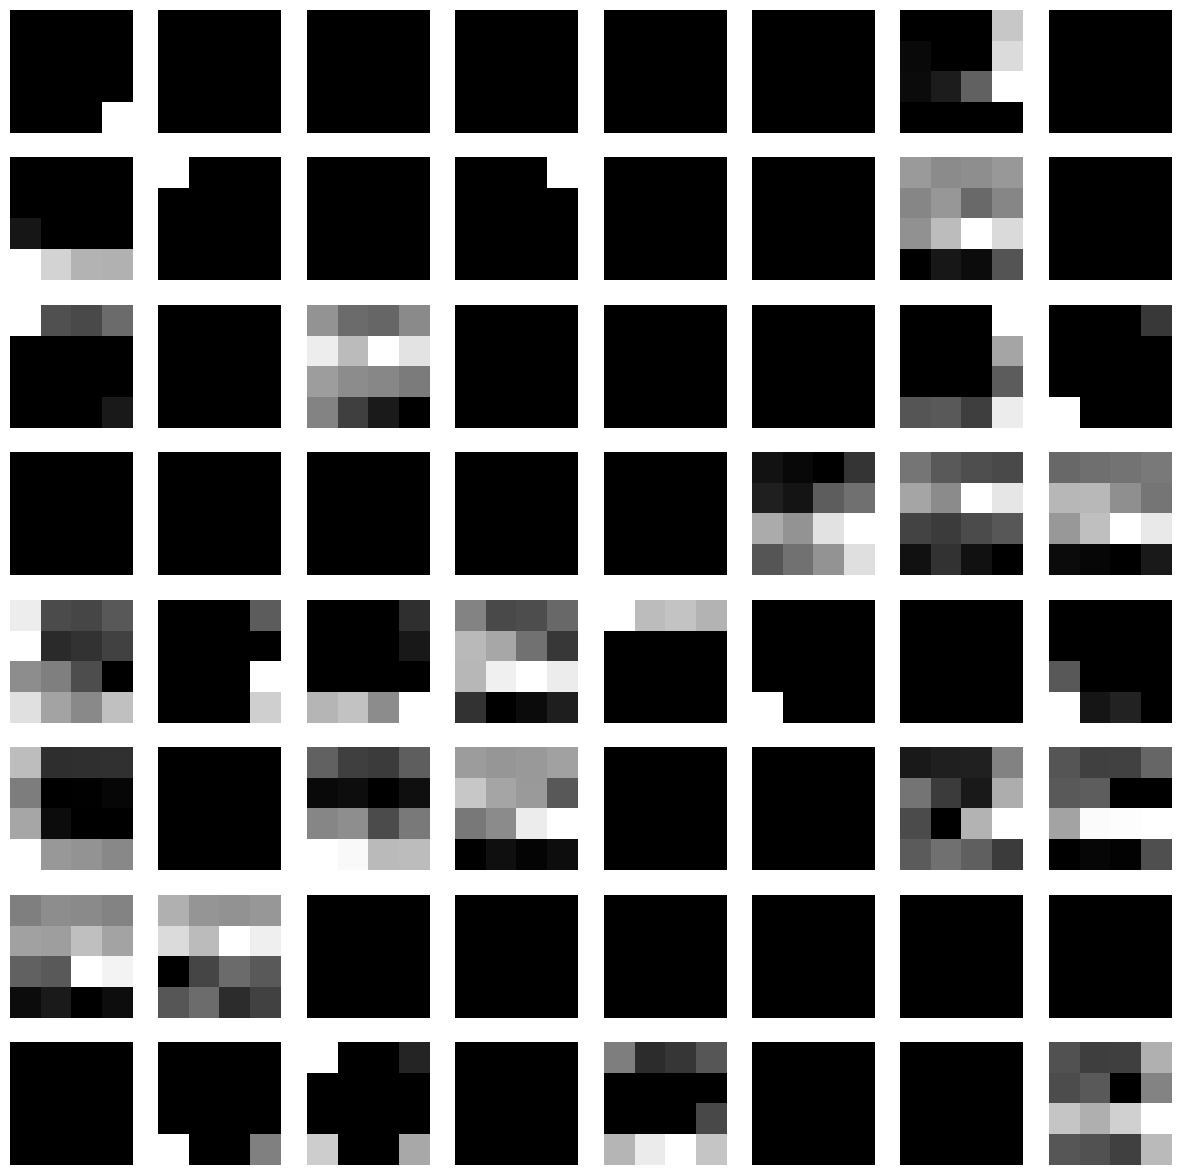

In [62]:
def visualize_feature_map(model, loader):
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs[:1]
            features = model.feature_extractor(inputs)
            feature_maps = features[0]
            break

    num_features = feature_maps.size(0)
    plt.figure(figsize=(15, 15))
    for i in range(num_features):
        plt.subplot(8, 8, i + 1)
        plt.imshow(feature_maps[i].cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

visualize_feature_map(model, trainloader)

Part A Feature Maps:
   - The feature maps appear more uniform and basic, focusing on identifying simple structures like edges and textures.
   - There is less differentiation between specific regions in the maps, indicating that the model is extracting foundational features.
   - These maps suggest that the model's feature extractor is not yet fully tuned to extract discriminative features required for separating classes effectively.

Part B Feature Maps:
   - The feature maps show significantly more diversity and localization of patterns.
   - Each map highlights distinct regions, indicating that the model has learned to focus on critical features that differentiate between classes.
   - There is better contrast, suggesting that the model is now extracting more specific and discriminative patterns.

Localization and Focus:
   - Part B maps show more defined and localized activations, which means the model is focusing on smaller, more meaningful areas of the input image.
   - In contrast, Part A maps are broader and less focused, covering larger areas with less precision.

Complexity of Features:
   - The features extracted in Part B are more complex, likely representing higher-level abstractions that are more relevant for classification.
   - Part A primarily captures low-level features like edges, while Part B captures semantic relationships.

Contrast and Clarity:
   - The contrast in Part B maps is higher, with stronger activations in key regions, indicating better learning and differentiation of important features.
   - Part A maps are less distinct, with weaker activations and more noise.


The changes in the feature maps from Part A to Part B highlight the progression of the model from learning basic to more advanced, class-specific features.

This improvement can be attributed to the combination of loss functions (Triplet Loss and Cross Entropy Loss), which guide the model to:
  - Structure the feature space effectively (Triplet Loss).
  - Focus on class-specific patterns for accurate classification (Cross Entropy Loss).
  
Part B's feature maps demonstrate a clear enhancement in the model's ability to extract discriminative features, leading to better classification performance.

c)

### Comparison and Conclusion: Cross Entropy Loss vs. Triplet Loss

#### 1. Quality of Feature Maps in Different Layers of the Network:
- Cross Entropy Loss:

  Produces general feature maps that are effective for classification but may not distinguish subtle inter-class relationships.

  Focuses primarily on extracting patterns directly correlated to the final classification task.

- Triplet Loss:

  Generates highly localized and discriminative feature maps.

  The maps focus on embedding semantic relationships between samples, resulting in better separation between classes in feature space.

#### 2. Final Accuracy on Test Data:
- Cross Entropy Loss:

  Generally provides a higher final accuracy in traditional classification tasks since it is optimized specifically for this goal.

- Triplet Loss:

  May result in slightly lower direct classification accuracy due to its focus on embedding learning rather than classification directly.

#### 3. Convergence Speed During Training:

- Cross Entropy Loss:

  Typically converges faster as it minimizes the classification error directly.

- Triplet Loss:

  Convergence is slower as it requires learning meaningful embeddings and minimizing triplet distance.

- Use Cross Entropy Lossfor tasks that focus purely on classification accuracy.

- Use Triplet Loss for applications that require embedding learning, such as similarity-based retrieval, clustering, or tasks where the generalization to new classes or complex feature extraction is crucial. For distinguishing fine-grained differences and extracting complex features, Triplet Loss is more suitable.

d)

In [66]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self, feature_extractor):
        super(CombinedModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        features = self.feature_extractor(x)
        x = features.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return features, x
    
def triplet_loss(anchor, positive, negative, margin=1.0):
    positive_dist = torch.nn.functional.pairwise_distance(anchor, positive)
    negative_dist = torch.nn.functional.pairwise_distance(anchor, negative)
    loss = torch.relu(positive_dist - negative_dist + margin)
    return loss.mean()


Epoch 1/10, Loss: 0.3206, Accuracy: 74.37%
Epoch 2/10, Loss: 0.2488, Accuracy: 84.16%
Epoch 3/10, Loss: 0.2420, Accuracy: 87.87%
Epoch 4/10, Loss: 0.2432, Accuracy: 90.03%
Epoch 5/10, Loss: 0.2050, Accuracy: 91.90%
Epoch 6/10, Loss: 0.2517, Accuracy: 92.94%
Epoch 7/10, Loss: 0.2400, Accuracy: 94.18%
Epoch 8/10, Loss: 0.2228, Accuracy: 94.63%
Epoch 9/10, Loss: 0.1961, Accuracy: 93.67%
Epoch 10/10, Loss: 0.2014, Accuracy: 94.88%


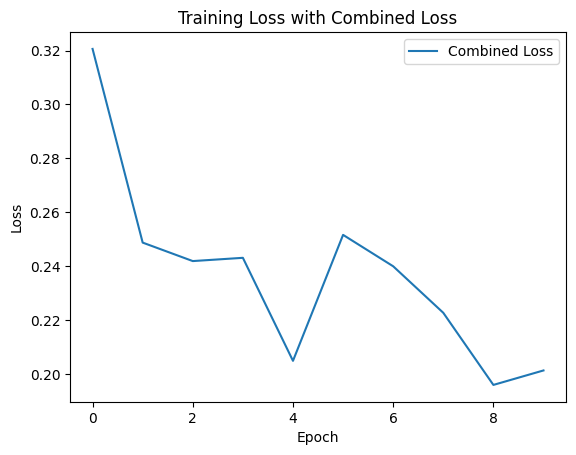

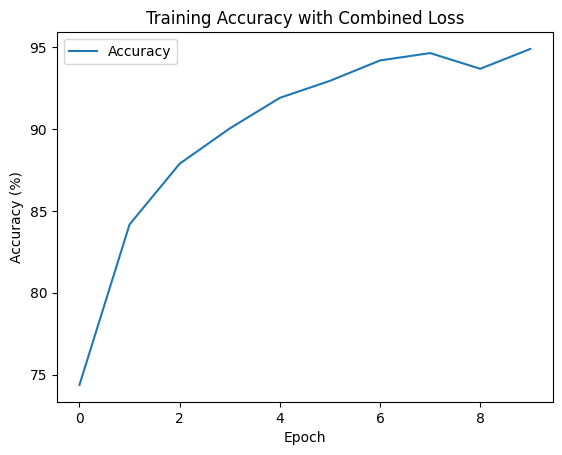

In [67]:
feature_extractor = FeatureExtractor()
model = CombinedModel(feature_extractor)
triplet_loss_fn = triplet_loss
cross_entropy_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        # Filter classes for airplane (0) and automobile (1)
        mask = (labels == 0) | (labels == 1)
        inputs, labels = inputs[mask], labels[mask]
        if len(inputs) < 30:
            continue

        # Create triplets
        anchor, positive, negative = inputs[:10], inputs[10:20], inputs[20:30]

        # Forward pass
        optimizer.zero_grad()
        anchor_features, _ = model(anchor)
        positive_features, _ = model(positive)
        negative_features, _ = model(negative)

        triplet_loss_value = triplet_loss_fn(anchor_features, positive_features, negative_features)

        _, classifier_outputs = model(inputs)
        cross_entropy_loss_value = cross_entropy_loss_fn(classifier_outputs, labels)

        # Combine losses
        total_loss_value = triplet_loss_value + cross_entropy_loss_value
        total_loss_value.backward()
        optimizer.step()

        total_loss += total_loss_value.item()
        _, predicted = torch.max(classifier_outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = total_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Step 6: Plot Loss and Accuracy
plt.figure()
plt.plot(range(num_epochs), train_loss, label='Combined Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with Combined Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(num_epochs), train_accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy with Combined Loss')
plt.legend()
plt.show()

In [ ]:
def evaluate_model_on_test(model, testloader):
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():  
        for inputs, labels in testloader:
            
            mask = (labels == 0) | (labels == 1)
            inputs, labels = inputs[mask], labels[mask]
            if len(inputs) == 0:
                continue

            # Forward pass
            _, outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Final Test Accuracy: {accuracy:.2f}%")
    return accuracy

test_accuracy = evaluate_model_on_test(model, testloader)


Final Test Accuracy: 93.90%


### Analysis of the Impact of Combining Loss Functions

#### Impact on Model Performance

Improved Feature Extraction:
   - Using Triplet Loss enables the model to learn features that are effective for distinguishing between similar and dissimilar samples.
   - This improvement in feature extraction directly enhances the performance of the classifier trained with Cross Entropy Loss.

Better Generalization:
   - The combination of the two losses helps the model generalize better, making it more effective at distinguishing between classes, even when encountering new or unseen data.

Reduced Sensitivity to Noise:
   - Triplet Loss encourages the model to focus on key, distinguishing features while ignoring irrelevant or noisy information.
   - As a result, the classifier’s decision-making, powered by Cross Entropy Loss, becomes more robust and reliable.

#### Why This Combination Works

Complementary Nature of the Losses:
   - Triplet Loss focuses on structuring the feature space, ensuring that similar samples are closer together while dissimilar ones are farther apart.
   - Cross Entropy Loss focuses on accurate final classification. Together, they create a balanced approach to learning.

Balancing Embedding and Classification:
   - Triplet Loss ensures the model organizes data in the feature space meaningfully.
   - Cross Entropy Loss capitalizes on these meaningful features to accurately assign class labels.

Multi-Objective Optimization:
   - By optimizing for both losses, the model becomes adept at not just separating data in the feature space but also excelling in the final classification task.
   - This approach is particularly effective for complex tasks or datasets with overlapping classes.


Overall, combining these two losses is especially powerful for challenging problems, where fine-grained distinctions and robust feature learning are crucial.

Q3)

A)

In [ ]:
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

print(mobilenet_v2)

input_size = (1, 3, 224, 224)  
dummy_input = torch.randn(input_size)

output = mobilenet_v2(dummy_input)
print("Output dimensions:", output.shape)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Architecture:

MobileNetV2 uses Inverted Residual blocks and Depthwise Separable Convolutions.
This structure reduces the number of parameters and improves computational efficiency, making it suitable for lightweight devices and real-time applications.
Input Dimensions:

The input images must have dimensions (3, 224, 224):
3 channels for RGB images.
Image size: 224x224 pixels.
Required Preprocessing for Input:

Resize: Resize the image to at least 256 pixels.
CenterCrop: Crop the center of the image to 224x224.
Normalize: Normalize the image with:
Mean: [0.485, 0.456, 0.406]
Standard deviation: [0.229, 0.224, 0.225].
Output Dimensions:

The output of the network is a vector of size (1, 1000).
This vector represents probabilities corresponding to the 1000 classes in the ImageNet dataset.

B)

Class: cougar, Probability: 0.9972438812255859
Class: lynx, Probability: 0.0013152832398191094
Class: lion, Probability: 0.0009848038898780942


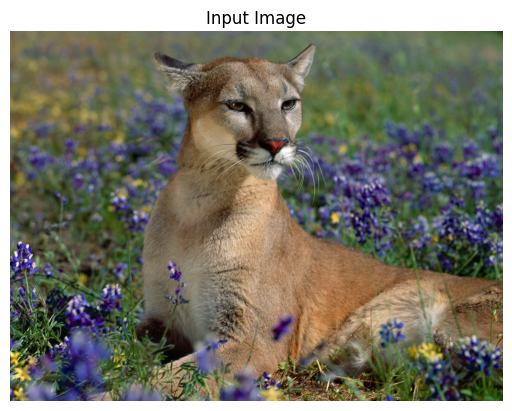

In [95]:
image_path = "Cougar Cute Desktop Animal Pictures.jpg"  
image = Image.open(image_path).convert("RGB")

mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v2.eval()  

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(image).unsqueeze(0)  

with torch.no_grad():
    output = mobilenet_v2(input_tensor)

probabilities = torch.nn.functional.softmax(output[0], dim=0)
top3_prob, top3_classes = torch.topk(probabilities, 3)

labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
class_labels = requests.get(labels_url).json()

for i in range(3):
    print(f"Class: {class_labels[top3_classes[i]]}, Probability: {top3_prob[i].item()}")

plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()


c)

In [8]:
from torchvision.datasets import Flowers102
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

# Load Flowers102 dataset
root_dir = "./flower_data"
datasets = {
    x: Flowers102(
        root=root_dir,
        split=x,
        transform=data_transforms[x],
        download=True
    )
    for x in ["train", "val", "test"]
}

dataloaders = {
    x: DataLoader(datasets[x], batch_size=32, shuffle=(x == "train"), num_workers=4)
    for x in ["train", "val", "test"]
}

dataset_sizes = {x: len(datasets[x]) for x in ["train", "val", "test"]}
print("Dataset sizes:", dataset_sizes)

num_classes = 102

mobilenet_v2 = models.mobilenet_v2(pretrained=True)
for param in mobilenet_v2.features.parameters():
    param.requires_grad = False

mobilenet_v2.classifier = nn.Sequential(
    nn.Linear(mobilenet_v2.last_channel, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)
mobilenet_v2 = mobilenet_v2.to(device)

Dataset sizes: {'train': 1020, 'val': 1020, 'test': 6149}


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.classifier.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, num_epochs=25):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return history


Dataset sizes: {'train': 1020, 'val': 1020, 'test': 6149}


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25
----------
train Loss: 4.5637 Acc: 0.0363
val Loss: 4.1771 Acc: 0.1941
Epoch 2/25
----------
train Loss: 3.8436 Acc: 0.1971
val Loss: 3.3861 Acc: 0.4696
Epoch 3/25
----------
train Loss: 3.0636 Acc: 0.3402
val Loss: 2.5822 Acc: 0.6078
Epoch 4/25
----------
train Loss: 2.4156 Acc: 0.4843
val Loss: 2.0147 Acc: 0.7020
Epoch 5/25
----------
train Loss: 1.8156 Acc: 0.6078
val Loss: 1.5978 Acc: 0.7422
Epoch 6/25
----------
train Loss: 1.4751 Acc: 0.6833
val Loss: 1.3109 Acc: 0.7814
Epoch 7/25
----------
train Loss: 1.1877 Acc: 0.7373
val Loss: 1.1258 Acc: 0.8137
Epoch 8/25
----------
train Loss: 0.9727 Acc: 0.7755
val Loss: 1.0172 Acc: 0.8049
Epoch 9/25
----------
train Loss: 0.9132 Acc: 0.7971
val Loss: 0.9276 Acc: 0.8127
Epoch 10/25
----------
train Loss: 0.7885 Acc: 0.8118
val Loss: 0.8663 Acc: 0.8206
Epoch 11/25
----------
train Loss: 0.6590 Acc: 0.8520
val Loss: 0.7895 Acc: 0.8402
Epoch 12/25
----------
train Loss: 0.5647 Acc: 0.8735
val Loss: 0.7452 Acc: 0.8353
Epoch 13/25
-

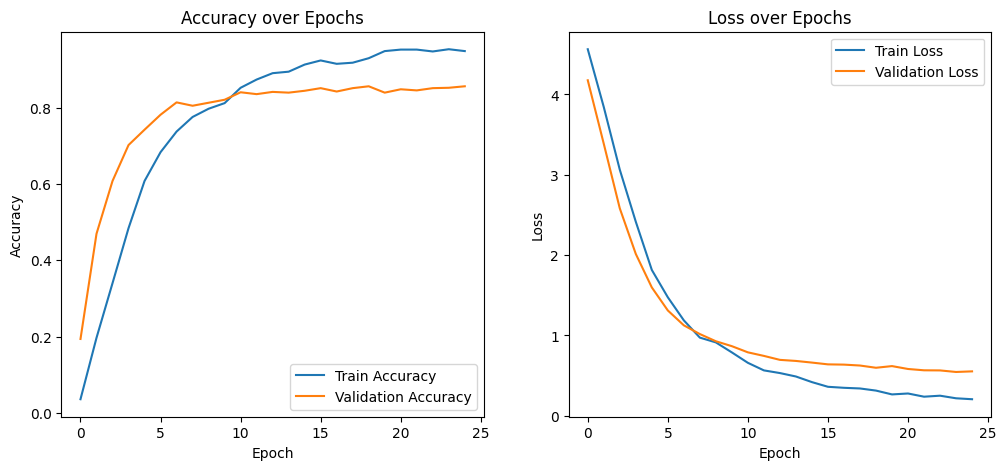

Test Loss: 0.6577, Test Accuracy: 0.8344


In [107]:
history = train_model(mobilenet_v2, criterion, optimizer, num_epochs=25)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    running_loss = 0.0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_corrects += torch.sum(preds == labels.data)
        running_loss += loss.item() * inputs.size(0)

    loss = running_loss / dataset_sizes["test"]
    accuracy = running_corrects.double() / dataset_sizes["test"]

    return loss, accuracy.item()

test_loss, test_acc = evaluate_model(mobilenet_v2, dataloaders["test"])
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

d)


In [108]:
def initialize_model(model_name, num_classes, feature_extract=True):
    if model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        set_parameter_requires_grad(model, feature_extract)
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, num_classes)
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        set_parameter_requires_grad(model, feature_extract)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        set_parameter_requires_grad(model, feature_extract)
        num_features = model.last_channel
        model.classifier[1] = nn.Linear(num_features, num_classes)
    else:
        raise ValueError("Invalid model name")
    return model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())
            print(f"{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    return history

models_to_test = ["vgg16", "resnet50", "mobilenet_v2"]
num_classes = 102
results = {}

for model_name in models_to_test:
    print(f"Training {model_name.upper()}")
    model = initialize_model(model_name, num_classes)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    history = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)
    results[model_name] = history

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name.upper()} Total Params: {total_params}, Trainable Params: {trainable_params}")

for model_name, history in results.items():
    print(f"Final Accuracy for {model_name.upper()}: {history['val_acc'][-1]:.4f}")


Training VGG16


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [05:25<00:00, 1.70MB/s]   


Epoch 1/5
----------
train Loss: 3.8143, Acc: 0.1853
val Loss: 2.1619, Acc: 0.5951
Epoch 2/5
----------
train Loss: 1.3512, Acc: 0.7314
val Loss: 1.4274, Acc: 0.7059
Epoch 3/5
----------
train Loss: 0.7364, Acc: 0.8529
val Loss: 1.1970, Acc: 0.7255
Epoch 4/5
----------
train Loss: 0.5172, Acc: 0.9167
val Loss: 1.0917, Acc: 0.7471
Epoch 5/5
----------
train Loss: 0.3897, Acc: 0.9294
val Loss: 1.0136, Acc: 0.7569
VGG16 Total Params: 134678438, Trainable Params: 417894
Training RESNET50


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5
----------
train Loss: 4.6150, Acc: 0.0971
val Loss: 3.3198, Acc: 0.3627
Epoch 2/5
----------
train Loss: 2.5763, Acc: 0.5775
val Loss: 2.1730, Acc: 0.6304
Epoch 3/5
----------
train Loss: 1.4966, Acc: 0.8255
val Loss: 1.5827, Acc: 0.7539
Epoch 4/5
----------
train Loss: 0.9479, Acc: 0.9127
val Loss: 1.2335, Acc: 0.8020
Epoch 5/5
----------
train Loss: 0.6270, Acc: 0.9588
val Loss: 1.0284, Acc: 0.8255
RESNET50 Total Params: 23717030, Trainable Params: 208998
Training MOBILENET_V2
Epoch 1/5
----------
train Loss: 4.3199, Acc: 0.1255
val Loss: 3.1797, Acc: 0.4637
Epoch 2/5
----------
train Loss: 2.3913, Acc: 0.6755
val Loss: 2.0163, Acc: 0.7098
Epoch 3/5
----------
train Loss: 1.3571, Acc: 0.8882
val Loss: 1.4483, Acc: 0.8049
Epoch 4/5
----------
train Loss: 0.8593, Acc: 0.9431
val Loss: 1.1552, Acc: 0.8392
Epoch 5/5
----------
train Loss: 0.5750, Acc: 0.9745
val Loss: 0.9756, Acc: 0.8549
MOBILENET_V2 Total Params: 2354534, Trainable Params: 130662
Final Accuracy for VGG16: 0.7

MobileNetV2 strikes the best balance between parameter efficiency and performance, making it the most suitable model for this task. VGG16, while having the most parameters, performs relatively worse, indicating diminishing returns from its larger architecture. ResNet50 provides a good compromise between parameter count and accuracy.

e)


Epoch 1/20
----------
train Loss: 4.6874 Acc: 0.0137
val Loss: 4.6377 Acc: 0.0098
Epoch 2/20
----------
train Loss: 4.5241 Acc: 0.0186
val Loss: 4.7242 Acc: 0.0098
Epoch 3/20
----------
train Loss: 4.3621 Acc: 0.0294
val Loss: 4.5029 Acc: 0.0235
Epoch 4/20
----------
train Loss: 4.1866 Acc: 0.0353
val Loss: 4.4834 Acc: 0.0363
Epoch 5/20
----------
train Loss: 4.0504 Acc: 0.0490
val Loss: 3.8938 Acc: 0.0529
Epoch 6/20
----------
train Loss: 3.9518 Acc: 0.0529
val Loss: 3.9385 Acc: 0.0539
Epoch 7/20
----------
train Loss: 3.8526 Acc: 0.0520
val Loss: 3.9519 Acc: 0.0588
Epoch 8/20
----------
train Loss: 3.8736 Acc: 0.0647
val Loss: 3.8518 Acc: 0.0618
Epoch 9/20
----------
train Loss: 3.7895 Acc: 0.0627
val Loss: 3.8471 Acc: 0.0725
Epoch 10/20
----------
train Loss: 3.6945 Acc: 0.0725
val Loss: 4.0482 Acc: 0.0569
Epoch 11/20
----------
train Loss: 3.6702 Acc: 0.0637
val Loss: 4.1157 Acc: 0.0667
Epoch 12/20
----------
train Loss: 3.7068 Acc: 0.0598
val Loss: 3.8586 Acc: 0.0696
Epoch 13/20
-

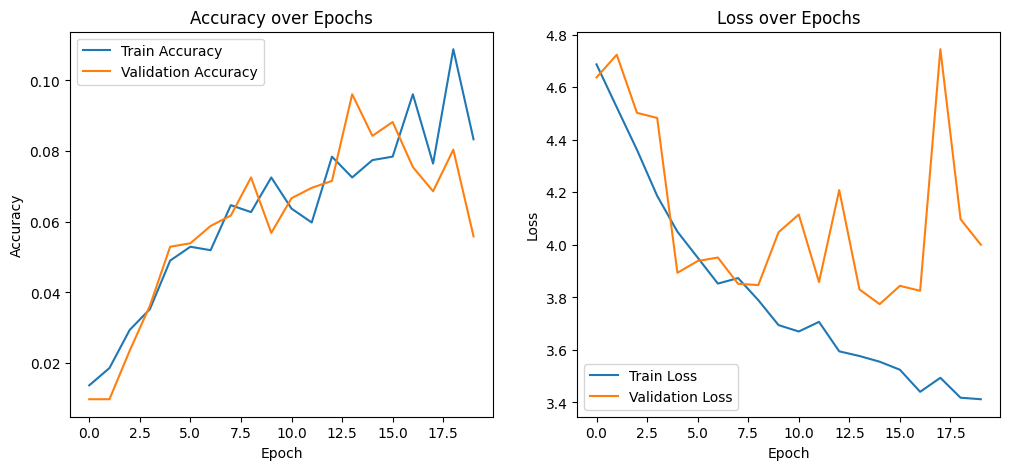

Test Loss: 4.0517, Test Accuracy: 0.0613


In [12]:
mobilenet_v2 = models.mobilenet_v2(pretrained=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2.to(device)

num_features = mobilenet_v2.last_channel
mobilenet_v2.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 102)  # 102 classes for Oxford Flower dataset
)
mobilenet_v2 = mobilenet_v2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet_v2.parameters(), lr=0.001)

def train_model(model, dataloaders, criterion, optimizer, num_epochs=20):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return history

history = train_model(mobilenet_v2, dataloaders, criterion, optimizer, num_epochs=20)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.show()

def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / dataset_sizes["test"]
    accuracy = running_corrects.double() / dataset_sizes["test"]
    return loss, accuracy.item()

test_loss, test_acc = evaluate_model(mobilenet_v2, dataloaders["test"], criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

When training MobileNetV2 from scratch (random initialization), the final accuracy is much lower compared to section (c) where transfer learning was used. Even with more epochs, the model struggles to reach the accuracy achieved with pretrained weights. This demonstrates the significant advantage of transfer learning, where pretrained knowledge helps the model converge faster and achieve higher accuracy on smaller datasets like Oxford 102 Flowers.